In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.random.set_seed(777)

In [3]:
tf.executing_eagerly()

True

# 정규화를 위한 함수 (최대 최소값이 1과 0이되도록 Scaling한다)

 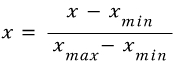

In [4]:
def normalization(data):
    # np.min(data, axis=None)
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator

# Data 선언
- X Data(feature)의 값은 해당 배열의 첫번째 값부터 4번째 값까지로 정의 되고 Y Data(label)는 해당 배열의 마지막 값을 정의(5번째 값)

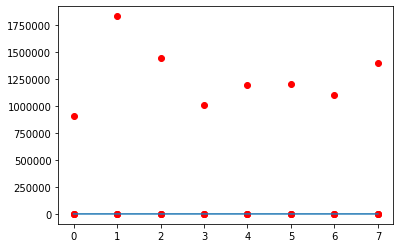

In [5]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

8

[[1.         1.         0.         1.         1.        ]
 [0.70548491 0.70439552 1.         0.71881783 0.83755792]
 [0.54412549 0.50274824 0.57608696 0.60646801 0.6606331 ]
 [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
 [0.51436    0.4258239  0.30434783 0.58504805 0.42624401]
 [0.49556179 0.4258239  0.31521739 0.48131134 0.49276137]
 [0.11436064 0.         0.20652174 0.22007776 0.18597238]
 [0.         0.07747099 0.5326087  0.         0.        ]]


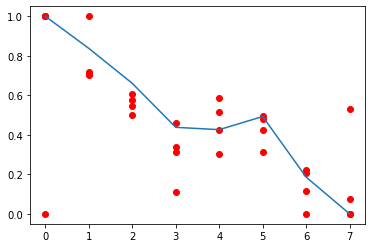

In [22]:
xy = normalization(xy)
print(xy)
x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)

plt.show()

- 첫번쨰 그래프의 경우 Outlier 값 때문에 그래프가 왜곡되어 보였다. 데이터를 정규화하여 0~1까지로 값을 제한하여 그래프를 다시 그렸다.

# Data를 LR 모델로 만들기
- Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
- X(features),Y(labels)는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [23]:
# tf.data.Dataset.from_tensor_slices(features, label)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(
    len(x_train))

W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal / tf.zeros)

In [24]:
W = tf.Variable(tf.random.normal((4,1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

Linear Regression의 Hypothesis를 정의한다 (y=Wx+b)

In [25]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

# L2 loss를 적용할 함수를 정의한다
- Weight의 수가 많아지면 수만큼 더한다
tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
- Weight 간의 값의 차이가 많이 날 경우 제대로 된 회귀를 할 수 없기 때문에 Weight 값들을 Regularized 해주는 것이다.

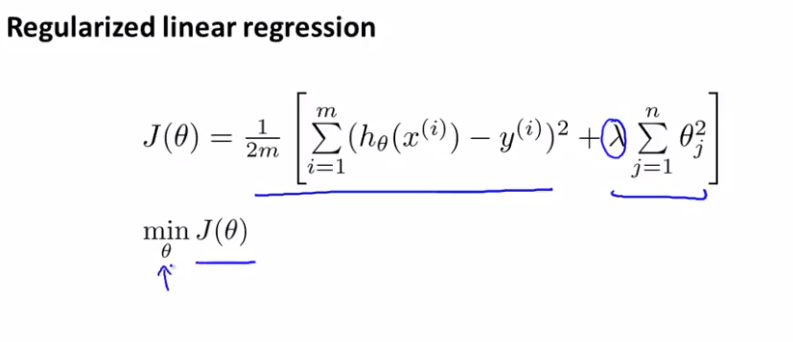

In [26]:
def l2_loss(loss, beta=0.01):
    # tf.nn.l2_loss(t): sum(t ** 2) / 2
    W_reg = tf.nn.l2_loss(W)
    loss = tf.reduce_mean(loss + W_reg * beta)
    return loss

가설을 검증할 Cost 함수를 정의한다(Mean Square Error를 사용)

In [27]:
def loss_fn(hypothesis, features, labels, flag=False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    if(flag):
        cost = l2_loss(cost)
    return cost

# Learning Rate 값을 조정하기 위한 Learning Decay 설정
5개 파라미터 설정
- starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
- global_step : 현재 학습 횟수
- 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
- 0.96 : 기존 learning에 곱할 값 
- 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
- decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [33]:
is_decay = True
starter_learning_rate = 0.1

if(is_decay):
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = starter_learning_rate, 
    decay_steps = 50,
    decay_rate = 0.96,
    staircase = True)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    optimizer = tf.keras.optimizers.SGD(learning_rate = starter_learning_rate)

def grad(hypothesis, features, labels, l2_flag):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features), features, labels,
                             l2_flag)
    return tape.gradient(loss_value, [W,b]), loss_value

# Tensorlfow를 통해 학습

In [34]:
EPOCHS = 101

for step in range(EPOCHS):
    for features, labels in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads, loss_value = grad(linearReg_fn(features), features, labels, False)
        # optimizer.apply_gradients(gvs):
        # gradient 값을 통하여 W 값을 얻어내기 위한 그래프를 생성함
        optimizer.apply_gradients(grads_and_vars = zip(grads, [W,b]))
        
    if step % 10 == 0:
        print('Iter: {}, Loss: {:.4f}'.format(step, loss_value))

Iter: 0, Loss: 0.5695
Iter: 10, Loss: 0.3125
Iter: 20, Loss: 0.2145
Iter: 30, Loss: 0.1514
Iter: 40, Loss: 0.1094
Iter: 50, Loss: 0.0807
Iter: 60, Loss: 0.0606
Iter: 70, Loss: 0.0462
Iter: 80, Loss: 0.0358
Iter: 90, Loss: 0.0282
Iter: 100, Loss: 0.0226
